# SIR Model with Time Dependent Parameters

## Assumptions
Homogenous mixing

Immunity after infection 

Same parameter values, and "static" policy 

### Setting Up Packages

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

### Set Input Parameters

In [2]:
### Parameters to Vary ###

# lambda: number of people that a susceptible person interacts with per time step
# p: probability of getting infected if a susceptible person interacts with an infectious person
# gamma: recovery rate (recovery probability within one time step)
lam, p, gamma = 3, 0.05, 1./14 # set lam = 2 vs 20, p = 0.3, gamma = 1/14

# probability of getting infected every time step
#beta = 1 - pow(1-p,lam)
beta = min(1, lam * p) # beta <= 1 by definition


In [3]:
### Fixed Parameters ###

# Total population.
N_total = 300000000

# Some vaccinated people are immune
N = N_total

# A grid of time points (in days) for the detecting period
t_set = np.linspace(0, 365, 366)

# Initial number of infected and immune individuals, I0 and R0.
I0, R0 = 10, 0

# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

### Model Engine

In [4]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

### Generate Trajectories for S(t), I(t), R(t)

In [5]:
# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t_set, args=(N, beta, gamma))
S, I, R = ret.T

# Here outputs S,I,R are trajectories over the simulation time horizon, 
# i.e., S is a vector of the numbers of susceptible people at each time step, check by printing it out:
#print S


### Plot Trajectories for S(t), I(t), R(t)

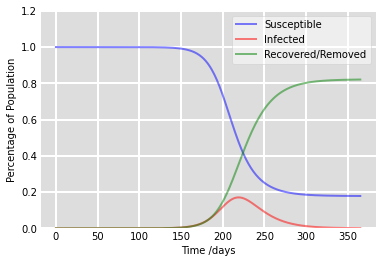

In [6]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t_set, S/N_total, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t_set, I/N_total, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t_set, R/N_total, 'g', alpha=0.5, lw=2, label='Recovered/Removed')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of Population')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## Time Dependent  R_0

In [7]:
L_shutdown = 50 # The day that R0 changed

L_relax = 125 # The day that restrictions are relaxed

In [8]:
# The SIR model differential equations.
def deriv_dynamic(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta(t) * S * I / N
    dIdt = beta(t) * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [9]:
def R_0_dynamic(t):
    value = 1.0
    if t < L_shutdown:
        value = 5.0
    elif t < L_relax:
        value = 0.9
    else:
        value = 1.5
    return value

def beta_dynamic(t):
    return R_0_dynamic(t) * gamma

In [10]:
## NOTE: The R_0_dynamic is the time dependent *basic reproduction number*, 
## it is not the same as the R0 below, the *initial number of recovered people*.

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_dynamic, y0, t_set, args=(N, beta_dynamic, gamma))
S, I, R = ret.T

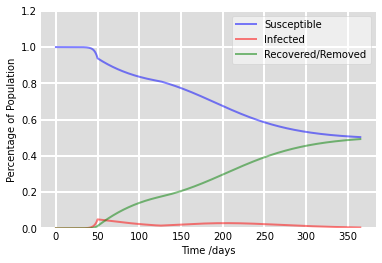

In [11]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t_set, S/N_total, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t_set, I/N_total, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t_set, R/N_total, 'g', alpha=0.5, lw=2, label='Recovered/Removed')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of Population')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## Smooth R_0 transition

Now we design a smoother transition for the basic reproduction number

$$R_0(t) = \frac{R_0^{start} - R_0^{end}}{1 + e^{-k(-x+x_0)}} + R_0^{end}$$

Here R_0^{start} and R_0^{end} are the starting and ending $R_0$ values that we want to interpolate between. 

$x_0$ is the inflection point of the transition, i.e., the day that $R_0$ changes most dramatically. You can interpret is the main lockdown day.

$k$ describes how fast R_0 change. Larger $k$ means faster change.

In [12]:
R_0_start, k, x0, R_0_end = 5.0, 0.5, 50, 0.9

def logistic_R_0(t):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def logistic_beta(t):
    return logistic_R_0(t) * gamma

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_dynamic, y0, t_set, args=(N, logistic_beta, gamma))
S, I, R = ret.T

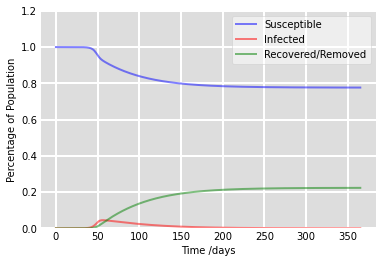

In [13]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t_set, S/N_total, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t_set, I/N_total, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t_set, R/N_total, 'g', alpha=0.5, lw=2, label='Recovered/Removed')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of Population')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## Fatality Estimation

In [14]:
supply = 2.9/1000 * N_total # 2.9 beds/1000 people
bedRatio = 0.1 # percent of patients that become critical 
lowFatality = 0.01 # death rate of non-critical patients
highFatality = 0.3 # death rate of critical patients

In [15]:
bedDemand = I * gamma * bedRatio
criticalD = np.clip(bedDemand - supply, 0, N_total)
noncriticalD = bedDemand - criticalD
D = noncriticalD * lowFatality + criticalD * highFatality
cumulativeD = np.cumsum(D)

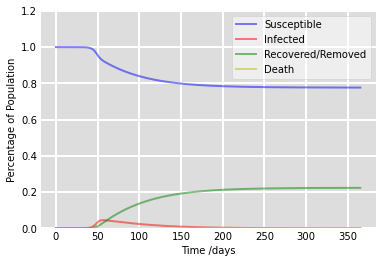

In [16]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t_set, S/N_total, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t_set, I/N_total, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t_set, R/N_total, 'g', alpha=0.5, lw=2, label='Recovered/Removed')
ax.plot(t_set, cumulativeD/N_total, 'y', alpha=0.5, lw=2, label='Death')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of Population')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()